In [ ]:
import os
from pathlib import Path

MNIST_DIR = Path('./MNIST')
print("All entries in ./MNIST:")
for p in sorted(MNIST_DIR.iterdir()):
    print(f"  {p}  {'[DIR]' if p.is_dir() else '[FILE]'}")

def find_real_file(basename):
    candidates = list(MNIST_DIR.glob(f'**/{basename}'))
    for c in candidates:
        if c.is_file():
            return c
    raise FileNotFoundError(f"Cannot find {basename} under {MNIST_DIR}")

train_img_file = find_real_file('train-images-idx3-ubyte')
train_lbl_file = find_real_file('train-labels-idx1-ubyte')
test_img_file  = find_real_file('t10k-images-idx3-ubyte')
test_lbl_file  = find_real_file('t10k-labels-idx1-ubyte')

print("\nSelected files:")
print(f"  Train images : {train_img_file}")
print(f"  Train labels : {train_lbl_file}")
print(f"  Test  images : {test_img_file}")
print(f"  Test  labels : {test_lbl_file}")

All entries in ./MNIST:
  MNIST/.ipynb_checkpoints  [DIR]
  MNIST/t10k-images-idx3-ubyte  [DIR]
  MNIST/t10k-images.idx3-ubyte  [FILE]
  MNIST/t10k-labels-idx1-ubyte  [DIR]
  MNIST/t10k-labels.idx1-ubyte  [FILE]
  MNIST/train-images-idx3-ubyte  [DIR]
  MNIST/train-images.idx3-ubyte  [FILE]
  MNIST/train-labels-idx1-ubyte  [DIR]
  MNIST/train-labels.idx1-ubyte  [FILE]

Selected files:
  Train images : MNIST/train-images-idx3-ubyte/train-images-idx3-ubyte
  Train labels : MNIST/train-labels-idx1-ubyte/train-labels-idx1-ubyte
  Test  images : MNIST/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
  Test  labels : MNIST/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte


In [ ]:
# MNIST reader and dataloaders
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

def _read_idx(filename):
    with open(filename, 'rb') as f:
        magic = f.read(4)
        if len(magic) != 4:
            raise ValueError(f"File too short: {filename}")
        data_type = magic[2]
        dims = magic[3]
        dtype_map = {0x08: np.uint8, 0x09: np.int8, 0x0B: np.int16,
                     0x0C: np.int32, 0x0D: np.float32, 0x0E: np.float64}
        np_dtype = dtype_map[data_type]
        shape = [int.from_bytes(f.read(4), 'big') for _ in range(dims)]
        data = np.frombuffer(f.read(), dtype=np_dtype)
        return data.reshape(shape)

def make_mnist_loaders(batch_size=64):
    X_tr = _read_idx(train_img_file)
    y_tr = _read_idx(train_lbl_file)
    X_te = _read_idx(test_img_file)
    y_te = _read_idx(test_lbl_file)

    # normalization
    X_tr = X_tr.astype(np.float32) / 255.0
    X_te = X_te.astype(np.float32) / 255.0
    mean, std = 0.1307, 0.3081
    X_tr = (X_tr - mean) / std
    X_te = (X_te - mean) / std

    X_tr = X_tr[:, None, :, :]      # (N,1,28,28)
    X_te = X_te[:, None, :, :]

    train_ds = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr).long())
    val_ds   = TensorDataset(torch.from_numpy(X_te), torch.from_numpy(y_te).long())

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=1000, shuffle=False)
    return train_loader, val_loader

train_loader, val_loader = make_mnist_loaders()
print(f"Train batches: {len(train_loader)}   Val batches: {len(val_loader)}")

Train batches: 938   Val batches: 10


In [ ]:
# CNN
import torch.nn as nn

class MNIST_CNN(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool  = nn.MaxPool2d(2)
        self.fc1   = nn.Linear(64*7*7, 128)
        self.fc2   = nn.Linear(128, 10)
        self.act   = activation
    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = self.act(self.fc1(x))
        return self.fc2(x)

In [ ]:
# Training / validation loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

def train_one_config(model, optimizer, train_loader, val_loader, epochs=15):
    model.to(device)
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)

    criterion = nn.CrossEntropyLoss()

    tr_loss, val_loss = [], []
    tr_acc , val_acc  = [], []

    for epoch in range(epochs):
        # train
        model.train()
        running_loss, correct = 0.0, 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X.size(0)
            correct += (out.argmax(1) == y).sum().item()
        tr_loss.append(running_loss / len(train_loader.dataset))
        tr_acc.append(correct / len(train_loader.dataset))

        # validate
        model.eval()
        v_loss, v_correct = 0.0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                out = model(X)
                v_loss += criterion(out, y).item() * X.size(0)
                v_correct += (out.argmax(1) == y).sum().item()
        val_loss.append(v_loss / len(val_loader.dataset))
        val_acc.append(v_correct / len(val_loader.dataset))

        print(f"Epoch {epoch+1:02d} | "
              f"TrainLoss {tr_loss[-1]:.4f} ValLoss {val_loss[-1]:.4f} | "
              f"TrainAcc {tr_acc[-1]:.4f} ValAcc {val_acc[-1]:.4f}")
    return tr_loss, val_loss, tr_acc, val_acc

Device: cuda


In [ ]:
# Optimizer hyper-parameter grids
opt_grids = {
    'SGD'     : [{'lr': lr, 'momentum': mom, 'weight_decay': 0.0}
                 for lr in [0.1, 0.01, 0.001]
                 for mom in [0.0, 0.5, 0.9]],
    'RMSProp' : [{'lr': lr, 'weight_decay': 0.0}
                 for lr in [1e-2, 5e-3, 1e-3, 5e-4]],
    'AdaGrad' : [{'lr': lr, 'weight_decay': 0.0}
                 for lr in [1e-1, 5e-2, 1e-2, 5e-3]],
    'Adam'    : [{'lr': lr, 'weight_decay': 0.0}
                 for lr in [1e-2, 5e-3, 1e-3, 5e-4]]
}


   OPTIMIZER SEARCH (ReLU)   


--- SGD ---

cfg → {'lr': 0.1, 'momentum': 0.0, 'weight_decay': 0.0}
Epoch 01 | TrainLoss 0.1862 ValLoss 0.0543 | TrainAcc 0.9406 ValAcc 0.9839
Epoch 02 | TrainLoss 0.0458 ValLoss 0.0300 | TrainAcc 0.9855 ValAcc 0.9904
Epoch 03 | TrainLoss 0.0316 ValLoss 0.0464 | TrainAcc 0.9898 ValAcc 0.9845
Epoch 04 | TrainLoss 0.0238 ValLoss 0.0280 | TrainAcc 0.9923 ValAcc 0.9915
Epoch 05 | TrainLoss 0.0176 ValLoss 0.0279 | TrainAcc 0.9947 ValAcc 0.9913
Epoch 06 | TrainLoss 0.0134 ValLoss 0.0350 | TrainAcc 0.9957 ValAcc 0.9900
Epoch 07 | TrainLoss 0.0111 ValLoss 0.0247 | TrainAcc 0.9968 ValAcc 0.9918
Epoch 08 | TrainLoss 0.0085 ValLoss 0.0252 | TrainAcc 0.9973 ValAcc 0.9928
Epoch 09 | TrainLoss 0.0063 ValLoss 0.0264 | TrainAcc 0.9982 ValAcc 0.9919
Epoch 10 | TrainLoss 0.0048 ValLoss 0.0313 | TrainAcc 0.9987 ValAcc 0.9906
Epoch 11 | TrainLoss 0.0040 ValLoss 0.0266 | TrainAcc 0.9990 ValAcc 0.9930
Epoch 12 | TrainLoss 0.0025 ValLoss 0.0265 | TrainAcc 0.9994 ValAcc 0.993

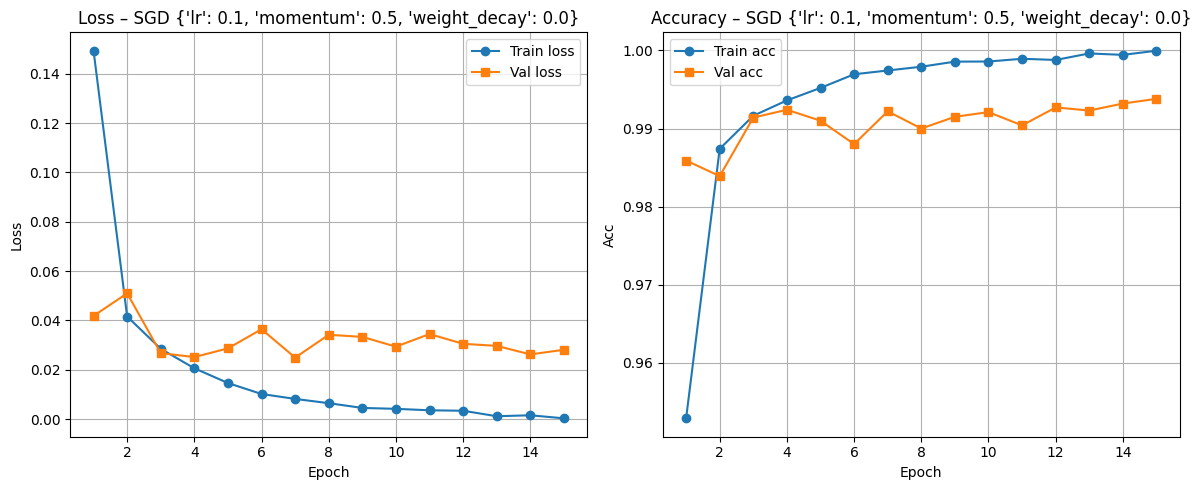

Saved → ./ex3_plots/best_SGD_{'lr':_0.1,_'momentum':_0.5,_'weight_decay':_0.0}.png


In [ ]:
# Running all configurations & keeping the best
import os, matplotlib.pyplot as plt
import torch.optim as optim

EPOCHS   = 15
ACT      = nn.ReLU()
PLOT_DIR = './ex3_plots'
os.makedirs(PLOT_DIR, exist_ok=True)

best_val_acc = 0.0
best_cfg     = None
history      = {}

print("\n   OPTIMIZER SEARCH (ReLU)   \n")
for opt_name, grid in opt_grids.items():
    print(f"\n--- {opt_name.upper()} ---")
    for cfg in grid:
        model = MNIST_CNN(ACT)

        if opt_name == 'SGD':
            optimizer = optim.SGD(model.parameters(),
                                  lr=cfg['lr'],
                                  momentum=cfg.get('momentum',0),
                                  weight_decay=cfg['weight_decay'])
        elif opt_name == 'RMSProp':
            optimizer = optim.RMSprop(model.parameters(),
                                      lr=cfg['lr'],
                                      weight_decay=cfg['weight_decay'])
        elif opt_name == 'AdaGrad':
            optimizer = optim.Adagrad(model.parameters(),
                                      lr=cfg['lr'],
                                      weight_decay=cfg['weight_decay'])
        else:  # Adam
            optimizer = optim.Adam(model.parameters(),
                                   lr=cfg['lr'],
                                   weight_decay=cfg['weight_decay'])

        print(f"\ncfg → {cfg}")
        tl, vl, ta, va = train_one_config(model, optimizer,
                                          train_loader, val_loader,
                                          epochs=EPOCHS)

        key = (opt_name, tuple(sorted(cfg.items())))
        history[key] = (tl, vl, ta, va)

        if va[-1] > best_val_acc:
            best_val_acc = va[-1]
            best_cfg     = (opt_name, cfg)
            best_hist    = (tl, vl, ta, va)

# Plotting the best result
def plot_best(tl, vl, ta, va, title):
    epochs = range(1, len(tl)+1)
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, tl, 'o-', label='Train loss')
    plt.plot(epochs, vl, 's-', label='Val loss')
    plt.title(f'Loss – {title}')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid()

    plt.subplot(1,2,2)
    plt.plot(epochs, ta, 'o-', label='Train acc')
    plt.plot(epochs, va, 's-', label='Val acc')
    plt.title(f'Accuracy – {title}')
    plt.xlabel('Epoch'); plt.ylabel('Acc'); plt.legend(); plt.grid()

    plt.tight_layout()
    fname = f"{PLOT_DIR}/best_{title.replace(' ','_')}.png"
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved → {fname}")

opt_name, cfg = best_cfg
title = f"{opt_name} {cfg}"
print("\n=== BEST RESULT ===")
print(f"Optimizer : {opt_name}")
print(f"Parameters: {cfg}")
print(f"Val Acc   : {best_val_acc:.4%}")
plot_best(*best_hist, title)

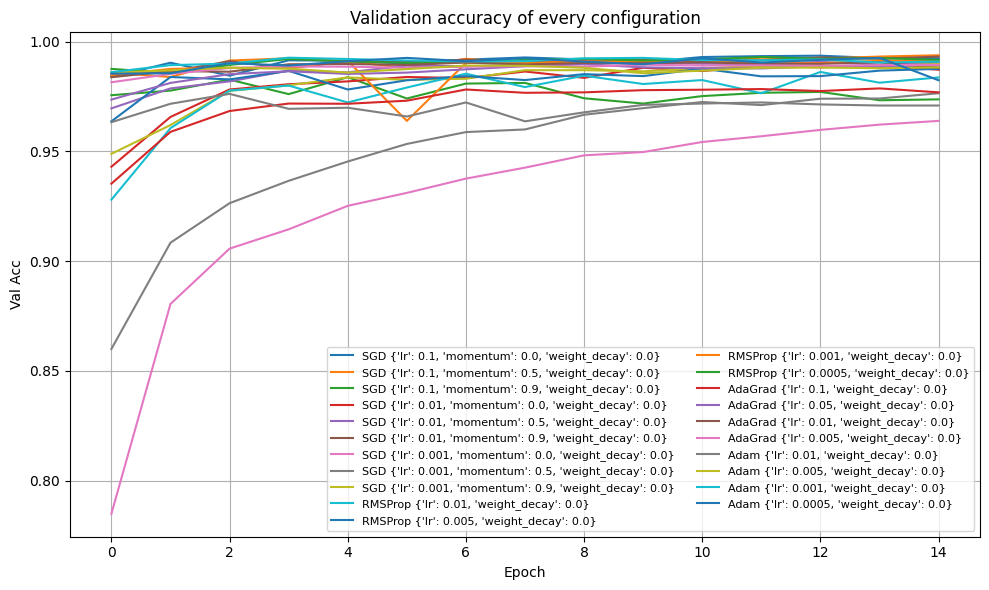

In [ ]:
# Overview of all runs
plt.figure(figsize=(10,6))
for (opt_name, cfg_key), (tl,vl,ta,va) in history.items():
    label = f"{opt_name} {dict(cfg_key)}"
    plt.plot(va, label=label)
plt.title('Validation accuracy of every configuration')
plt.xlabel('Epoch'); plt.ylabel('Val Acc'); plt.legend(fontsize=8, ncol=2)
plt.grid(); plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/all_val_acc.png", dpi=150)
plt.show()